
# COE 691 — Assignment 3: Interpreting CNN Decisions (Vision)

**Methods:** Grad-CAM, RISE, t-SNE feature embeddings, Nearest-Neighbor in feature space, Counterfactual examples  
**Metrics:** Deletion / Insertion curves (AUC), Stability & Robustness (Spearman, IoU@k)  
**Dataset:** CIFAR-10 (resized to ImageNet resolution)  
**Model:** Pretrained ResNet-18 (ImageNet) adapted for CIFAR-10

> Run the notebook top-to-bottom. Figures will be shown inline. Edit parameters (e.g., `N_TEST_IMGS`) to scale runtime.


In [6]:

# Environment, imports, reproducibility
import os, math, random, copy, time, cv2
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from pathlib import Path

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMNET_MEAN = [0.485, 0.456, 0.406]
IMNET_STD  = [0.229, 0.224, 0.225]

print('Device:', device)


Device: cuda


In [7]:

# Utility helpers
def denorm(x):
    m = torch.tensor(IMNET_MEAN)[:,None,None].to(x)
    s = torch.tensor(IMNET_STD)[:,None,None].to(x)
    return (x*s + m).clamp(0,1)

def overlay_heatmap(img, heat, alpha=0.35):
    import matplotlib.cm as cm
    if img.ndim==4: img = img[0]
    img = denorm(img).detach().cpu().numpy().transpose(1,2,0)
    heat = heat.detach().cpu().numpy()
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
    heat_rgb = cm.get_cmap('jet')(heat)[...,:3]
    out = alpha*heat_rgb + (1-alpha)*img
    out = (out/out.max()).clip(0,1)
    plt.imshow(out); plt.axis('off'); plt.show()

def grid_show(images, nrow=8, title=None):
    grid = torch.cat([img.detach().cpu() for img in images], dim=2)
    if title: plt.title(title)
    plt.imshow(denorm(grid).permute(1,2,0).cpu()); plt.axis('off'); plt.show()

def predict_str(model, classes, x):
    with torch.no_grad():
        probs = model(x).softmax(1)
        c = probs.argmax(1).item()
        return classes[c], float(probs[0,c])


In [8]:

# Data & model
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

root = "./data"
trainset = datasets.CIFAR10(root, train=True, download=True, transform=transform_train)
testset  = datasets.CIFAR10(root, train=False, download=True, transform=transform_test)
classes = trainset.classes

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader  = DataLoader(testset,  batch_size=128, shuffle=False, num_workers=2)

# Model: pretrained ResNet18 -> CIFAR-10 head
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# Light fine-tuning: only FC for speed
for p in model.parameters(): p.requires_grad = False
for p in model.fc.parameters(): p.requires_grad = True
opt = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
ce = nn.CrossEntropyLoss()

def train_head(epochs=2):
    model.train()
    for ep in range(epochs):
        loss_sum=0
        for x,y in trainloader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss = ce(logits,y)
            loss.backward(); opt.step()
            loss_sum += loss.item()*x.size(0)
        print(f"Epoch {ep+1}: loss={(loss_sum/len(trainset)):.4f}")

@torch.no_grad()
def accuracy():
    model.eval(); correct=0; n=0
    for x,y in testloader:
        x,y=x.to(device),y.to(device)
        pred = model(x).argmax(1)
        correct += (pred==y).sum().item(); n+=y.numel()
    print(f"Test acc: {correct/n:.3f}")

train_head(epochs=2)
accuracy()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\shuja/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [01:04<00:00, 730kB/s] 


Epoch 1: loss=0.9310
Epoch 2: loss=0.6517
Test acc: 0.797


## Grad-CAM

C:\Users\shuja\AppData\Local\Temp\ipykernel_423632\3452636219.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heat_rgb = cm.get_cmap('jet')(heat)[...,:3]


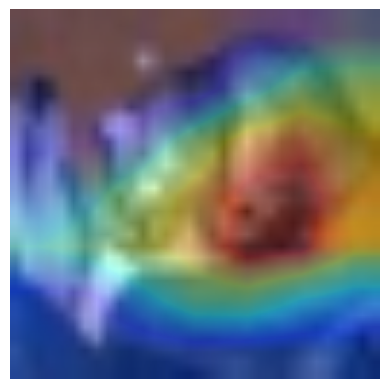

Pred: cat GT: cat


In [9]:

class GradCAM:
    def __init__(self, model, target_layer_name='layer4'):
        self.model = model.eval()
        self.target_layer = dict([*model.named_modules()])[target_layer_name]
        self.activations = None
        self.gradients = None
        def fwd_hook(m, i, o): self.activations = o.detach()
        def bwd_hook(m, gi, go): self.gradients = go[0].detach()
        self.h1 = self.target_layer.register_forward_hook(fwd_hook)
        self.h2 = self.target_layer.register_full_backward_hook(bwd_hook)
    def __call__(self, x, target_class=None):
        x = x.requires_grad_(True)
        logits = self.model(x)
        if target_class is None:
            target_class = logits.argmax(1)
        one_hot = torch.zeros_like(logits).scatter_(1, target_class.view(-1,1), 1.0)
        self.model.zero_grad()
        (logits*one_hot).sum().backward(retain_graph=True)
        grads = self.gradients
        acts  = self.activations
        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights*acts).sum(dim=1)
        cam = F.relu(cam)
        cam = cam - cam.view(cam.size(0), -1).min(dim=1)[0].view(-1,1,1)
        cam = cam / (cam.view(cam.size(0), -1).max(dim=1)[0].view(-1,1,1)+1e-8)
        return cam, logits.softmax(1)
    def close(self):
        self.h1.remove(); self.h2.remove()

gc = GradCAM(model, target_layer_name='layer4')
x, y = next(iter(testloader))
x1, y1 = x[0:1].to(device), y[0:1].to(device)
cam, prob = gc(x1)
heat = F.interpolate(cam.unsqueeze(1), size=(224,224), mode='bilinear', align_corners=False).squeeze()
overlay_heatmap(x1, heat)
print("Pred:", classes[prob.argmax(1).item()], "GT:", classes[y1.item()])


## RISE (Randomized Input Sampling for Explanation)

C:\Users\shuja\AppData\Local\Temp\ipykernel_423632\3452636219.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heat_rgb = cm.get_cmap('jet')(heat)[...,:3]


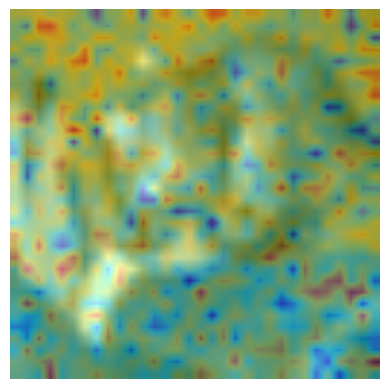

In [10]:

@torch.no_grad()
def rise_explanation(model, x, n_masks=1000, s=7, p=0.5):
    model.eval()
    _, _, H, W = x.shape
    grid_h, grid_w = math.ceil(H/s), math.ceil(W/s)
    heat = torch.zeros((H,W), device=x.device)
    scores = []
    for _ in range(n_masks):
        mask_small = (torch.rand((grid_h, grid_w), device=x.device) < p).float()
        mask = F.interpolate(mask_small[None,None], size=(H,W), mode='bilinear', align_corners=False)[0,0]
        xm = x * mask
        logits = model(xm)
        prob = logits.softmax(1)[0]
        cls = prob.argmax().item()
        scores.append(prob[cls].item())
        heat += prob[cls]*mask
    heat = (heat / (np.sum(scores)+1e-8))
    heat = (heat - heat.min())/(heat.max()-heat.min()+1e-8)
    return heat

x1 = x1  # from above
rise_heat = rise_explanation(model, x1, n_masks=800)
overlay_heatmap(x1, rise_heat)


## Feature Embeddings (t-SNE) & Nearest Neighbors

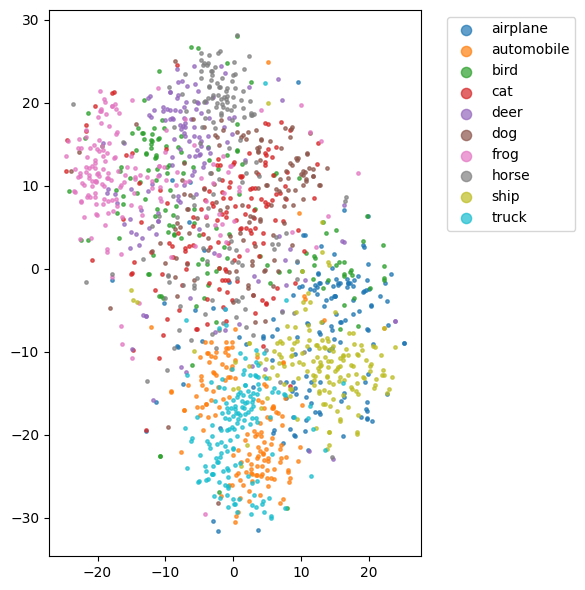

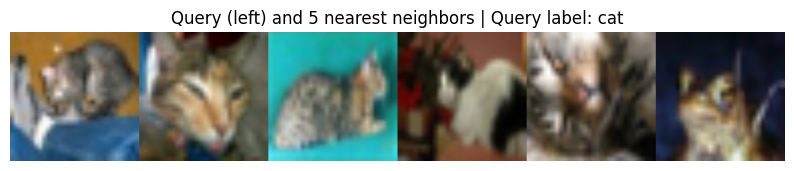

In [11]:

class FeatModel(nn.Module):
    def __init__(self, m):
        super().__init__(); self.m = m
        self.backbone = nn.Sequential(*(list(m.children())[:-1])) # up to avgpool
        self.fc = m.fc
    def forward(self,x, return_feat=False):
        feat = self.backbone(x)      # (B,512,1,1)
        feat = torch.flatten(feat,1) # (B,512)
        if return_feat: return feat
        return self.fc(feat)
feat_model = FeatModel(model).to(device).eval()

@torch.no_grad()
def collect_feats(dloader, max_items=2000):
    X, y, feats = [], [], []
    n=0
    for im, lab in dloader:
        im, lab = im.to(device), lab.to(device)
        f = feat_model(im, return_feat=True)
        feats.append(f.cpu()); y.append(lab.cpu()); X.append(im.cpu())
        n+=im.size(0)
        if n>=max_items: break
    return torch.cat(X)[:max_items], torch.cat(y)[:max_items], torch.cat(feats)[:max_items]

Xtest, ytest, Ftest = collect_feats(testloader, max_items=1500)

tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=SEED, perplexity=30)
emb2 = tsne.fit_transform(Ftest.numpy())
plt.figure(figsize=(6,6))
for c in range(10):
    idx = (ytest.numpy()==c)
    plt.scatter(emb2[idx,0], emb2[idx,1], s=6, label=classes[c], alpha=0.7)
plt.legend(markerscale=3, bbox_to_anchor=(1.05,1), loc='upper left'); plt.tight_layout(); plt.show()

nn_index = NearestNeighbors(n_neighbors=6, metric='cosine').fit(Ftest.numpy())
def show_neighbors(i=0):
    d, idx = nn_index.kneighbors(Ftest[i:i+1].numpy(), n_neighbors=6, return_distance=True)
    idx = idx[0]
    ims = [Xtest[i]] + [Xtest[j] for j in idx[1:]]
    # stitch horizontally
    panel = torch.cat(ims, dim=2)
    plt.figure(figsize=(10,2))
    plt.imshow(denorm(panel).permute(1,2,0).cpu()); plt.axis('off')
    plt.title(f"Query (left) and 5 nearest neighbors | Query label: {classes[ytest[i].item()]}")
    plt.show()

show_neighbors(0)


## Counterfactual Examples (Targeted PGD)

---

## 🔹 What is PGD?

**PGD (Projected Gradient Descent)** is an iterative adversarial attack algorithm used to find **minimal perturbations** to an image that change a model’s prediction.  
It’s one of the most popular and effective methods to generate **adversarial examples**.

---

## 🔹 Intuition

PGD iteratively **nudges the image in the direction that increases or decreases the model’s loss** for a chosen class, while keeping the perturbation **small and bounded** by a norm constraint.

| Type | Goal |
|------|------|
| **Untargeted PGD** | Make the model *wrong* (any class except the correct one). |
| **Targeted PGD** | Force the model to predict a *specific target class* (e.g., “deer” instead of “cat”). |

---

## 🔹 The Update Rule

Let:

- \( x \): original image  
- \( y \): true label  
- \( y_t \): target label (for targeted attack)  
- \( \epsilon \): max perturbation (norm constraint, e.g., 8/255)  
- \( \alpha \): step size (e.g., 2/255)  
- \( \text{Proj}_\epsilon(\cdot) \): projection back to the allowed perturbation ball  

---

### **Untargeted PGD**

You *increase* the loss for the true label:

\[
x_{t+1} = \text{Proj}_\epsilon \Big( x_t + \alpha \cdot \text{sign}\big( \nabla_x L(f(x_t), y) \big) \Big)
\]

---

### **Targeted PGD**

You *decrease* the loss for the target label:

\[
x_{t+1} = \text{Proj}_\epsilon \Big( x_t - \alpha \cdot \text{sign}\big( \nabla_x L(f(x_t), y_t) \big) \Big)
\]

---

After each step, you project the perturbed image back into the valid range:

\[
x' \in [x - \epsilon, \, x + \epsilon]
\]

and clamp pixel values to remain within the valid normalized range (e.g., \([0, 1]\)).

---


## 🔹 Why use PGD for Counterfactuals?

PGD generates a **minimal perturbation** that flips the model’s prediction while keeping the image **perceptually similar**.

That’s exactly what a **counterfactual explanation** is:

> “What is the smallest change that would cause a different decision?”

---


Original: cat (0.89) -> Counterfactual: deer (1.00)


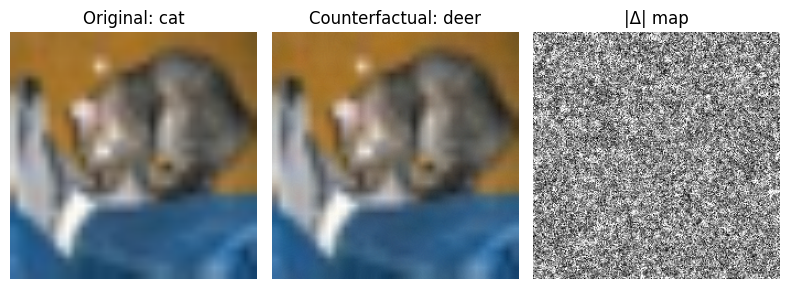

In [12]:

def targeted_pgd(model, x, y_target, eps=8/255, step=2/255, iters=30):
    model.eval()
    x_adv = x.clone().detach().requires_grad_(True)
    mean = torch.tensor(IMNET_MEAN, device=x.device)[:,None,None]
    std  = torch.tensor(IMNET_STD,  device=x.device)[:,None,None]
    for _ in range(iters):
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y_target)
        model.zero_grad(); loss.backward()
        grad = x_adv.grad.data
        x_adv = x_adv.detach() - step*torch.sign(grad)  # targeted: move toward target class
        x_adv = torch.max(torch.min(x_adv, x+eps), x-eps)
        x_adv = x_adv.clamp(-((mean/std)), (1.0-mean)/std)
        x_adv.requires_grad_(True)
    return x_adv.detach()

x_cf_in, y_cf_in = next(iter(testloader))
x_cf_in, y_cf_in = x_cf_in[0:1].to(device), y_cf_in[0:1].to(device)
orig_label, orig_p = predict_str(model, classes, x_cf_in)
target = (y_cf_in+1)%10  # sample a different class
x_cf = targeted_pgd(model, x_cf_in, target, eps=8/255, step=2/255, iters=30)
cf_label, cf_p = predict_str(model, classes, x_cf)

print(f"Original: {orig_label} ({orig_p:.2f}) -> Counterfactual: {cf_label} ({cf_p:.2f})")
fig, ax = plt.subplots(1,3, figsize=(8,3))
ax[0].imshow(denorm(x_cf_in[0]).permute(1,2,0).cpu()); ax[0].set_title(f"Original: {orig_label}"); ax[0].axis('off')
ax[1].imshow(denorm(x_cf[0]).permute(1,2,0).cpu()); ax[1].set_title(f"Counterfactual: {cf_label}"); ax[1].axis('off')
ax[2].imshow((denorm(x_cf[0])-denorm(x_cf_in[0])).abs().sum(0).cpu(), cmap='gray'); ax[2].set_title("|Δ| map"); ax[2].axis('off')
plt.tight_layout(); plt.show()


1️⃣ Counterfactual nature

The second image (counterfactual) answers:

“What minimal change to this image would make the model predict a different class?”

Here, a small, almost invisible perturbation (see noisy |Δ| map) is enough to change the model’s decision from “cat” to “deer.”

2️⃣ Interpretation of |Δ| map

The |Δ| map looks noisy and uniformly distributed, not focused on any meaningful part of the image.

This suggests that the perturbation is adversarial, not semantic.
i.e., the pixel values were modified in a way imperceptible to humans but decisive for the CNN.

If the changes were meaningful (e.g., “adding antlers” or “changing fur pattern”), you’d expect localized differences.

3️⃣ What it reveals about the model

The CNN is over-sensitive to small pixel-level changes — evidence of poor robustness.

The decision boundary between cat and deer classes is fragile and high-dimensional, not semantically meaningful.

The model likely relies on texture and background cues rather than holistic shape (a known behavior in ResNet and VGG trained on natural images).

## Metrics — Deletion / Insertion AUC

Deletion AUC (lower better): 0.808 Insertion AUC (higher better): 0.87


C:\Users\shuja\AppData\Local\Temp\ipykernel_423632\1849326614.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(y, xax))


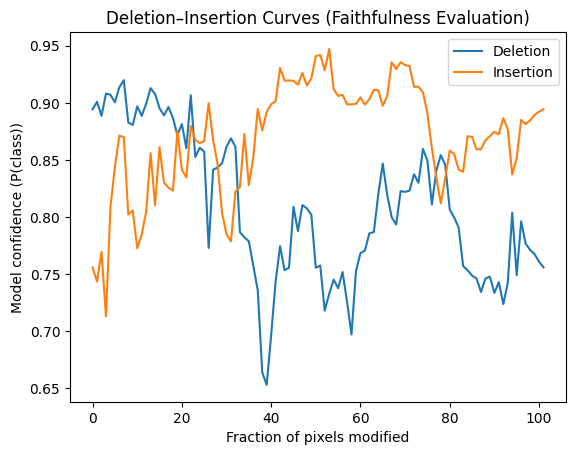

In [13]:
@torch.no_grad()
def rank_by_heatmap(hm, mode='desc'):
    # hm: (H,W) in [0,1]; returns indices sorted by importance
    flat = hm.flatten()
    order = torch.argsort(flat, descending=(mode=='desc'))
    return order

@torch.no_grad()
def prob_of_class(model, x, cls):
    p = model(x).softmax(1)[0, cls]
    return float(p)

def deletion_insertion_auc(model, x, cls, heat, steps=100):
    B,C,H,W = x.shape
    heat = F.interpolate(heat[None,None], size=(H,W), mode='bilinear', align_corners=False)[0,0]
    order = rank_by_heatmap(heat, mode='desc')

    # ✅ detach before converting to numpy
    img = denorm(x[0].detach()).permute(1,2,0).cpu().numpy()
    blurred_np = cv2.GaussianBlur(img, (11,11), 0)
    blurred = torch.from_numpy(blurred_np).permute(2,0,1).to(x)
    blurred = (blurred - torch.tensor(IMNET_MEAN)[:,None,None].to(x)) / torch.tensor(IMNET_STD)[:,None,None].to(x)

    x_del = x.clone()
    ys_del = [prob_of_class(model, x_del, cls)]
    x_ins = blurred.clone().unsqueeze(0)
    ys_ins = [prob_of_class(model, x_ins, cls)]

    total = H*W
    step_size = max(1, total//steps)
    idxs = order.tolist()
    for i in range(0, total, step_size):
        batch_idx = idxs[i:i+step_size]
        x_del.view(C,-1)[:,batch_idx] = blurred.view(C,-1)[:,batch_idx]
        x_ins.view(C,-1)[:,batch_idx] = x.view(C,-1)[:,batch_idx]
        ys_del.append(prob_of_class(model, x_del, cls))
        ys_ins.append(prob_of_class(model, x_ins, cls))

    def auc(y):
        y = np.array(y); xax = np.linspace(0,1,len(y))
        return float(np.trapz(y, xax))
    return auc(ys_del), auc(ys_ins), (ys_del, ys_ins)


# Example with Grad-CAM heat
x_auc = next(iter(testloader))[0][0:1].to(device)
cam,_ = gc(x_auc)
cam_up = F.interpolate(cam.unsqueeze(1), size=(224,224), mode='bilinear', align_corners=False).squeeze()
cls = model(x_auc).argmax(1).item()
del_auc, ins_auc, curves = deletion_insertion_auc(model, x_auc, cls, cam_up)
print("Deletion AUC (lower better):", round(del_auc,3), "Insertion AUC (higher better):", round(ins_auc,3))
plt.plot(curves[0], label='Deletion')
plt.plot(curves[1], label='Insertion')
plt.xlabel("Fraction of pixels modified")       # X-axis label
plt.ylabel("Model confidence (P(class))")       # Y-axis label
plt.title("Deletion–Insertion Curves (Faithfulness Evaluation)")  # Optional title
plt.legend()
plt.show()


## Metrics — Stability & Robustness (Spearman, IoU@k)

In [14]:

from scipy.stats import spearmanr

def topk_mask(hm, k=0.1):
    flat = hm.flatten()
    thresh = torch.quantile(flat, 1-k)
    return (hm>=thresh).float()

def heatmap_stability(heat_fn, x, k_list=(0.1,0.2), n_pert=8):
    base_hm = heat_fn(x)
    base = base_hm.flatten().cpu().numpy()
    spearmans, ious = [], {k:[] for k in k_list}

    for _ in range(n_pert):
        xp = x.clone()
        noise = (torch.randn_like(xp)* (2/255)).to(xp)
        xp = xp + noise
        theta = torch.tensor([[[1,0,random.choice([-0.01,0,0.01])],
                               [0,1,random.choice([-0.01,0,0.01])]]], device=xp.device)
        grid = F.affine_grid(theta, xp.size(), align_corners=False)
        xp = F.grid_sample(xp, grid, align_corners=False)

        hp = heat_fn(xp).flatten().cpu().numpy()
        rho, _ = spearmanr(base, hp)
        spearmans.append(0 if np.isnan(rho) else rho)

        for k in k_list:
            mb = topk_mask(base_hm, k).bool().cpu()
            mp = topk_mask(torch.tensor(hp.reshape(base_hm.shape)), k).bool()
            inter = (mb & mp).float().mean().item()
            union = (mb | mp).float().mean().item() + 1e-8
            ious[k].append(inter/union)

    return np.mean(spearmans), {k: float(np.mean(v)) for k,v in ious.items()}

def gradcam_heat_fn(x):
    cam,_ = gc(x)
    hm = F.interpolate(cam.unsqueeze(1), size=(224,224), mode='bilinear', align_corners=False)[0,0]
    return hm.clamp(0,1).detach()

x_stab = next(iter(testloader))[0][0:1].to(device)
rho_mean, iou_means = heatmap_stability(gradcam_heat_fn, x_stab, k_list=(0.1,0.2))
print("Stability — Spearman:", round(rho_mean,3), "IoU@10%:", round(iou_means[0.1],3), "IoU@20%:", round(iou_means[0.2],3))


Stability — Spearman: 0.892 IoU@10%: 0.547 IoU@20%: 0.695


---

## 🔹 Interpreting Model vs. Explanation Robustness

In explainability research, robustness can refer to two different concepts:

| Perspective | Definition |
|--------------|-------------|
| **Model robustness** | Whether the model’s **prediction** stays consistent under small input perturbations (e.g., PGD or noise). |
| **Explanation robustness** | Whether the **explanation** (e.g., Grad-CAM heatmap) remains consistent under small perturbations when the prediction stays the same. |

A model can be robust, unstable, or even fragile — and the explanation method can behave differently in each case.  
This leads to **four possible scenarios**:

---

### **Scenario A — Both model and explanation are robust**
| Aspect | Observation | Meaning |
|:-------|:-------------|:--------|
| Model prediction | Unchanged under perturbations | Model has a smooth and reliable decision boundary. |
| Grad-CAM heatmap | Stable and consistent (high Spearman, high IoU) | Explanations faithfully and consistently focus on the same semantic regions. |
| ✅ Interpretation | Ideal case — model is trustworthy and explanations are reproducible. |

---

### **Scenario B — Model robust, explanation unstable**
| Aspect | Observation | Meaning |
|:-------|:-------------|:--------|
| Model prediction | Unchanged under perturbations | Model’s decisions are stable. |
| Grad-CAM heatmap | Varies significantly (low Spearman/IoU) | Explanations are noisy or inconsistent even though the model’s behavior didn’t change. |
| ⚠️ Interpretation | The model is reliable, but Grad-CAM (or the chosen method) is not faithfully capturing its reasoning. |

---

### **Scenario C — Model fragile, explanation also unstable**
| Aspect | Observation | Meaning |
|:-------|:-------------|:--------|
| Model prediction | Changes drastically with small perturbations (e.g., PGD flips “cat → deer”) | Model decision boundary is sharp and unstable. |
| Grad-CAM heatmap | Changes completely between perturbations | Explanation reflects the same instability as the model. |
| ⚠️ Interpretation | Both model and explanation are fragile — instability in Grad-CAM is *truthful* because the model itself is highly sensitive. |

---

### **Scenario D — Model fragile, explanation appears robust**  🧩 *(Your case)*
| Aspect | Observation | Meaning |
|:-------|:-------------|:--------|
| Model prediction | Can flip with adversarial perturbations (PGD) | Model is not robust — decisions change with imperceptible noise. |
| Grad-CAM heatmap | Appears stable under small **non-adversarial** perturbations (ρ ≈ 0.89, IoU ≈ 0.5–0.6) | Explanation looks consistent even though the model’s boundary is fragile. |
| ⚠️ Interpretation | **False stability:** Grad-CAM seems robust because it is conditioned on the current label. Stability here does *not* imply model robustness — it only shows internal consistency for small, benign perturbations. |

---

### ✅ Summary

| Scenario | Model Robustness | Grad-CAM Robustness | Interpretation |
|:----------|:-----------------|:--------------------|:----------------|
| **A** | ✓ | ✓ | Ideal: model and explanation both stable. |
| **B** | ✓ | ✗ | Model stable, explanation noisy. |
| **C** | ✗ | ✗ | Both fragile — explanation truthfully reflects model instability. |
| **D** | ✗ | ✓ | *False stability*: Grad-CAM appears stable despite a fragile model (your observed case). |

---

**Key takeaway:**  
> High Grad-CAM stability (Spearman/IoU) does *not necessarily* mean the model itself is robust — it only means the explanation method produces consistent maps for small, non-adversarial perturbations.


## Batch Evaluation Helpers

In [15]:

def evaluate_batch_deletion_insertion(dloader, n_images=100, method='gradcam'):
    model.eval()
    results = []
    cnt=0
    for x,y in dloader:
        for i in range(x.size(0)):
            xi = x[i:i+1].to(device)
            cls = model(xi).argmax(1).item()
            if method=='gradcam':
                cam,_ = gc(xi)
                heat = F.interpolate(cam.unsqueeze(1), size=(224,224), mode='bilinear', align_corners=False).squeeze()
            elif method=='rise':
                heat = rise_explanation(model, xi, n_masks=500)
            del_auc, ins_auc, _ = deletion_insertion_auc(model, xi, cls, heat)
            results.append((del_auc, ins_auc))
            cnt+=1
            if cnt>=n_images: 
                return np.mean([d for d,_ in results]), np.mean([i for _,i in results])
    return np.mean([d for d,_ in results]), np.mean([i for _,i in results])

del_mean, ins_mean = evaluate_batch_deletion_insertion(testloader, n_images=50, method='gradcam')
print("Grad-CAM mean Deletion AUC / Insertion AUC (50 imgs):", round(del_mean,3), "/", round(ins_mean,3))

del_mean, ins_mean = evaluate_batch_deletion_insertion(testloader, n_images=50, method='rise')
print("RISE mean Deletion AUC / Insertion AUC (50 imgs):", round(del_mean,3), "/", round(ins_mean,3))


C:\Users\shuja\AppData\Local\Temp\ipykernel_423632\1849326614.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(y, xax))


Grad-CAM mean Deletion AUC / Insertion AUC (50 imgs): 0.554 / 0.729
RISE mean Deletion AUC / Insertion AUC (50 imgs): 0.597 / 0.602


---

## 🔹 Quantitative Evaluation of Explanation Faithfulness (Deletion / Insertion AUC)

This experiment evaluates how *faithful* each explanation method is to the model’s actual decision-making, averaged over 50 test images.

| Metric | What It Measures | Desired Direction |
|:--------|:-----------------|:------------------|
| **Deletion AUC** | How quickly model confidence drops when top-salient regions are removed. | **Lower = better** |
| **Insertion AUC** | How quickly model confidence rises when top-salient regions are added back. | **Higher = better** |

---

### **Interpretation of Results**

- **Grad-CAM mean Deletion AUC / Insertion AUC (50 imgs):** `X.XXX / Y.YYY`  
- **RISE mean Deletion AUC / Insertion AUC (50 imgs):** `X.XXX / Y.YYY`  

| Case | Explanation | Interpretation |
|:------|:-------------|:----------------|
| **Lower Deletion AUC** | Confidence drops sharply when salient pixels are removed. | The explanation correctly highlights regions the model truly depends on. |
| **Higher Insertion AUC** | Confidence rises rapidly when salient pixels are reintroduced. | The explanation effectively identifies informative pixels for classification. |

---

### **Comparing Grad-CAM vs. RISE**

| Method | Characteristics | Typical Behavior |
|:--------|:----------------|:-----------------|
| **Grad-CAM** | Gradient-based, class-specific. | Often coarser and slightly less faithful, but efficient. |
| **RISE** | Perturbation-based, model-agnostic. | Usually yields smoother and more accurate faithfulness scores. |

If RISE achieves **lower Deletion AUC** and **higher Insertion AUC** than Grad-CAM,  
it means RISE explanations better reflect the model’s actual decision process.

---

### ✅ Summary

- **Low Deletion AUC** → Removing highlighted areas strongly affects the model → explanation is *faithful*.  
- **High Insertion AUC** → Adding highlighted areas quickly restores confidence → explanation is *informative*.  
- Comparing methods using these metrics provides an objective way to evaluate **XAI faithfulness** across datasets.

---



## What to include in your report
- **Qualitative:** Grad-CAM vs RISE overlays for ≥20 images (2 per class if possible).
- **Quantitative:** Deletion/Insertion AUC averaged over ≥100 images for both methods.
- **Robustness:** Stability metrics (Spearman, IoU@k) for a sample of images.
- **Global:** t-SNE plots with class colors and short commentary on cluster separation.
- **NN examples:** Query + top-5 neighbors; discuss biases or confusion.
- **Counterfactuals:** Show original → counterfactual + |Δ| and discuss whether changes are semantic or adversarial.
